In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load
#
# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#
# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
#
# # import os
# # for dirname, _, filenames in os.walk('/kaggle/input'):
# #     for filename in filenames:
# #         print(os.path.join(dirname, filename))
#
# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
import os


class Config:
	DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


class RecognitionConfig:
	DATASET_PATH = '/kaggle/input/ocrdataset/datasets/ocr-datasets'
	TOKENIZER_PATH = os.path.join(DATASET_PATH, 'tokenizer.txt') # we don't actually use this
	H = 40


In [3]:
# import sys
# sys.path.append('..')

import numpy as np
import os
from functools import reduce


""" Map from character to index and the other way """
class DumbTokenizer():
	def __init__(self):

		# <CTC> : Placeholder for CTC loss as "non-character"
		# <PAD> : Placeholder for padding the short labels
		# <UNK> : Placeholder for unknown character
		# <EOW> : End of word
		vocabs = ["<CTC>", "<PAD>", "<UNK>", "<EOW>"] + \
		         list("abcdefghijklmnopqrstuvwxyz0123456789") + \
		         list("abcdefghijklmnopqrstuvwxyz".upper())
		self.vocab_size = len(vocabs)
		self.char_to_idx = dict()
		self.idx_to_char = []
		for i, c in enumerate(vocabs):
			self.char_to_idx[c] = i
			self.idx_to_char.append(c)


	def encode(self, word):
		ret = []
		for c in word:
			ret.append(
				self.char_to_idx.get(c, self.char_to_idx['<UNK>'])
			)
		ret += [self.char_to_idx["<EOW>"]]
		return np.array(ret)

	def decode(self, idx, ignore_repeat=False):
		ret = ""
		prev = 0
		for i in idx:
			if i != self.char_to_idx["<CTC>"]:
				if i == prev and ignore_repeat:
					pass
				else:
					ret += self.idx_to_char[i]
			prev = i
			# ret += self.idx_to_char[i]
		return ret

In [3]:
import os
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from skimage.transform import resize
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torchvision import transforms

def collate_fn(batch, tokenizer):
    # make different images the same size
    #    pad the small image with 0,
    #    pad the short labels with "<PAD>"

    # return:
	# 	imgs: (batch_size, 3, H, W), where H = Config.H, W is the maximum width of the images in the batch
	# 	labels: (batch_size, max_label_length)
	# 	widths: (batch_size) the actual width of the images in the batch before padding
	#	label_lengths: (batch_size) the actual length of the labels in the batch before padding


	imgs, labels, widths, label_lengths = zip(*batch)
	maxw = max(widths)

	imgs = torch.stack(
		[
			F.pad(imgs[i], [0, maxw - widths[i]]) for i in range(len(imgs))
		], dim=0
	)
	labels = pad_sequence(labels, batch_first=True, padding_value=tokenizer.char_to_idx['<PAD>'])

	return imgs, labels, torch.Tensor(widths).long(), torch.Tensor(label_lengths).long()


class Synth25K(Dataset):
	def __init__(self, tokenizer, split='train'):
		self.split = split
		self.tokenizer = tokenizer

		self.fnames = []
		self.labels = []

		lines = open(
			os.path.join(RecognitionConfig.DATASET_PATH, 'Synth25KFrom90K/annotations-training.txt')
		).readlines()
		for l in lines:
			f, l = l.strip().split(' ')
			self.fnames.append(
				os.path.join(
					RecognitionConfig.DATASET_PATH, 'Synth25KFrom90K',
					*f.split('/')[1:],
				)
			)
			self.labels.append(self.tokenizer.encode(l))

		idx = int(len(self.fnames) * 0.9)
		if self.split == 'train':
			self.fnames = self.fnames[:idx]
			self.labels = self.labels[:idx]
		else:
			self.fnames = self.fnames[idx:]
			self.labels = self.labels[idx:]


		self.collate_fn = lambda x: collate_fn(x, self.tokenizer)

	def __len__(self):
		return len(self.fnames)

	def __getitem__(self, idx):
		# Resize the image to have height = Config.H
		img = plt.imread(self.fnames[idx])
		h, w, _ = img.shape
		w = w * RecognitionConfig.H // h
		h = RecognitionConfig.H
		img = resize(img, (h, w), anti_aliasing=True)

		label = self.labels[idx]

		return torch.Tensor(img).permute(2, 0, 1), torch.Tensor(label).long(), w, len(label)



In [13]:
import torch
from torch import nn



class ConvNormRelu(nn.Module):
	def __init__(self, nin, nout, kernel_size, stride, padding):
		super(ConvNormRelu, self).__init__()
		self.nn = nn.Sequential(
			nn.Conv2d(nin, nout, kernel_size, stride, padding),
			nn.BatchNorm2d(nout),
			nn.LeakyReLU()
		)

	def forward(self, x):
		return self.nn(x)

class CRNN(nn.Module):
	def __init__(self, tokenizer, model_dim=512):
		super(CRNN, self).__init__()
		self.model_dim = model_dim
		self.tokenizer = tokenizer
		self.cnn = nn.Sequential(
			ConvNormRelu(3, 64, 3, 1, 1), # [batch, 64, 40, 160]
			ConvNormRelu(64, 64, 3, 1, 1),  # [batch, 64, 40, 160]
			ConvNormRelu(64, 64, 2, 2, 0), # [batch, 64, 20, 80]

			ConvNormRelu(64, 128, 3, 1, 1), # [batch, 128, 20, 80]
# 			ConvNormRelu(128, 128, 3, 1, 1), # [batch, 128, 20, 80]
			ConvNormRelu(128, 128, 2, 2, 0), # [batch, 128, 10, 40]

			ConvNormRelu(128, 256, 3, 1, 1), # [batch, 256, 10, 40]
			ConvNormRelu(256, 256, 2, 2, 0), # [batch, 256, 5, 20]

			ConvNormRelu(256, 256, 3, 1, 1), # [batch, 256, 5, 20]
# 			ConvNormRelu(256, 256, 3, 1, 1),  # [batch, 256, 5, 20]
		)
		self.downsample_factor = 8 # hard-coded in CNN

		self.nn = nn.Sequential(
			nn.Linear(256 * 5, self.model_dim),
			nn.LeakyReLU(),
			nn.Dropout(0.2),
			nn.Linear(self.model_dim, self.model_dim),
		)

		self.rnn = nn.GRU(
			input_size=self.model_dim,
			hidden_size=self.model_dim,
			num_layers=2,
			batch_first=True,
			bidirectional=True
		)

		self.classification = nn.Sequential(
			nn.Linear(self.model_dim * 2, self.model_dim),
			nn.LeakyReLU(),
			nn.Linear(self.model_dim, self.tokenizer.vocab_size)
		)

	def forward(self, x, widths):
		x = self.cnn(x)
		x = torch.flatten(x, start_dim=1, end_dim=2) # [batch, 256 * 5, T]
		x = torch.permute(x, (0, 2, 1)) # [batch, 10, 1024]
		x = self.nn(x)
		x, h = self.rnn(x)
		return self.classification(x), widths // self.downsample_factor

	def predict(self, img):
		# img: [3, H, W]
		self.eval()
		_, _, w = img.shape
		img = img[None, ...]
		preds, _ = self(img, torch.tensor([w]).to(Config.DEVICE))
		preds = torch.argmax(preds[0], dim=-1).detach().cpu().numpy()
		return self.tokenizer.decode(preds, ignore_repeat=True)




In [14]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader


def train():
	epochs = 100
	# tokenizer = Tokenizer(RecognitionConfig.TOKENIZER_PATH)
	tokenizer = DumbTokenizer()
	ds_train = Synth25K(tokenizer, 'train')
	dl_train = DataLoader(ds_train, batch_size=32, shuffle=True, collate_fn=ds_train.collate_fn)
	ds_val = Synth25K(tokenizer, 'val')

	model = CRNN(tokenizer)
	model = model.to(Config.DEVICE)
# 	ckpt = torch.load('/kaggle/input/crnnckpt/60.pth')['model']
# 	model.load_state_dict(ckpt)
	optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
	criterion = nn.CTCLoss(blank=tokenizer.char_to_idx['<CTC>'], zero_infinity=True)

	for e in range(epochs):
		for i, (imgs, labels, widths, label_lengths) in enumerate(dl_train):
			model.train()
			imgs = imgs.to(Config.DEVICE)
			labels = labels.to(Config.DEVICE)
			widths = widths.to(Config.DEVICE)
			label_lengths = label_lengths.to(Config.DEVICE)

			preds, pred_lengths = model(imgs, widths)
			loss = criterion(
				preds.log_softmax(-1).permute(1, 0, 2),
				labels,
				pred_lengths,
				label_lengths
			)

			optimizer.zero_grad()
			loss.backward()
			torch.nn.utils.clip_grad_norm_(model.parameters(), 0.3)
			optimizer.step()

			if i % 200 == 0:
				print(e, loss.item())
				idx = np.random.randint(0, len(ds_val))
				img, label, width, label_length = ds_val[idx]
				plt.imshow(img.permute(1, 2, 0))
				plt.show()

				pred = model.predict(img.to(Config.DEVICE))
				print(pred)
				print(tokenizer.decode(label))

		if e % 5 == 0:
			torch.save(
				{'model': model.state_dict()},
				'./%d.pth' % e
			)




0 6.967974662780762


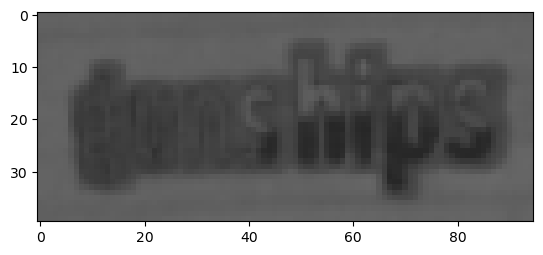


gunships<EOW>
1 3.1875948905944824


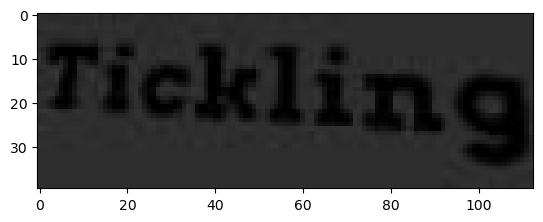

S<EOW>
Tickling<EOW>
2 3.1763172149658203


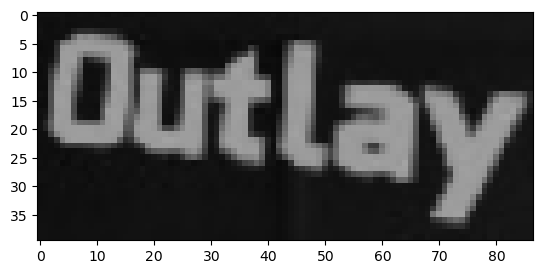

Ss<EOW>
Outlay<EOW>
3 3.2211828231811523


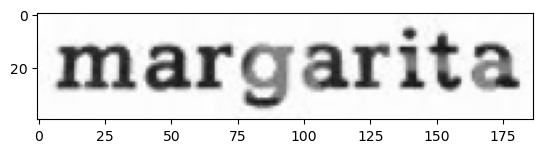

cas<EOW>
margarita<EOW>
4 3.0687737464904785


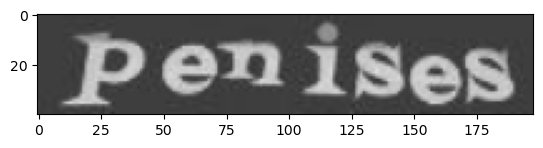

Ses<EOW>
penises<EOW>
5 2.9169156551361084


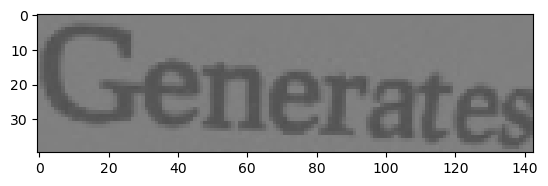

Sas<EOW>
Generates<EOW>
6 2.8388514518737793


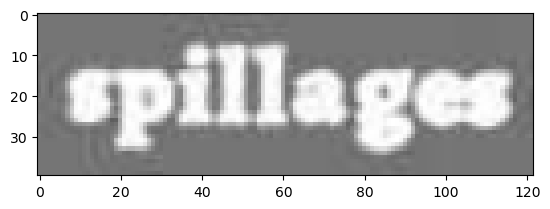

cos<EOW>
spillages<EOW>
7 2.7125649452209473


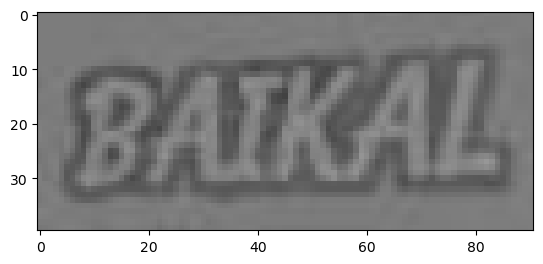

Sa<EOW>
BAIKAL<EOW>
8 2.4525365829467773


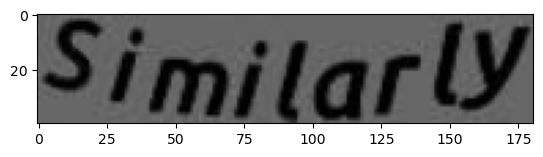

Sll<EOW>
Similarly<EOW>
9 2.768028497695923


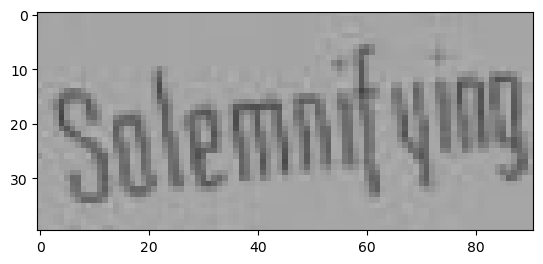

dhd<EOW>
Solemnifying<EOW>
10 2.2457332611083984


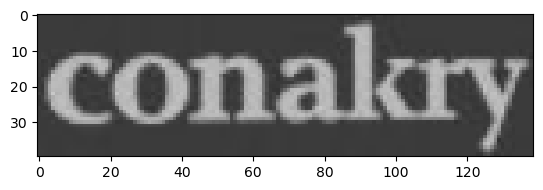

rocly<EOW>
conakry<EOW>
11 2.1744213104248047


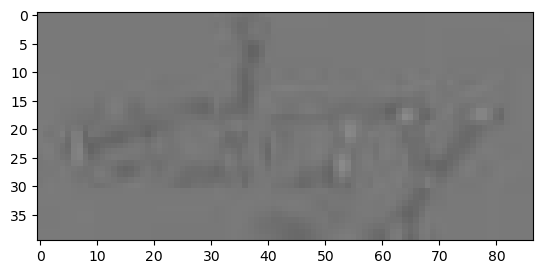

clas<EOW>
edgy<EOW>
12 1.5963538885116577


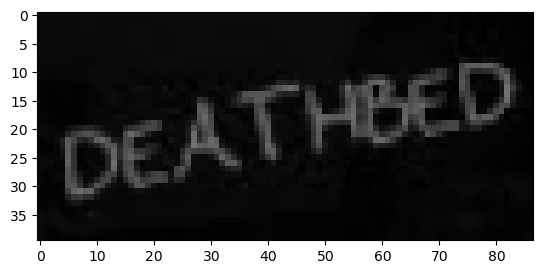

ceOTes<EOW>
DEATHBED<EOW>
13 1.7965688705444336


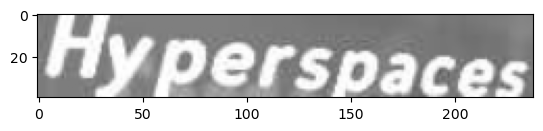

hwrersnsres<EOW>
Hyperspaces<EOW>
14 1.3034050464630127


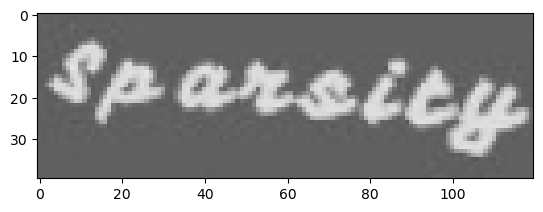

Hrottiy<EOW>
Sparsity<EOW>
15 0.9333077073097229


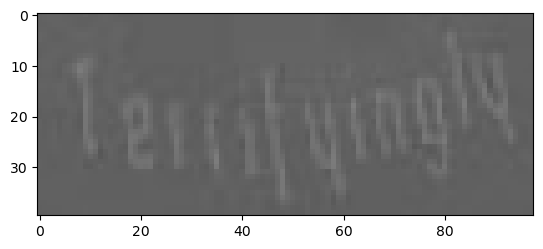

Jolus<EOW>
Terrifyingly<EOW>
16 0.8217064142227173


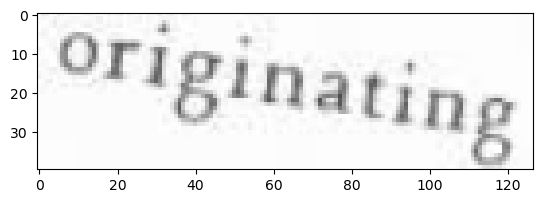

onghiating<EOW>
originating<EOW>
17 0.7107594609260559


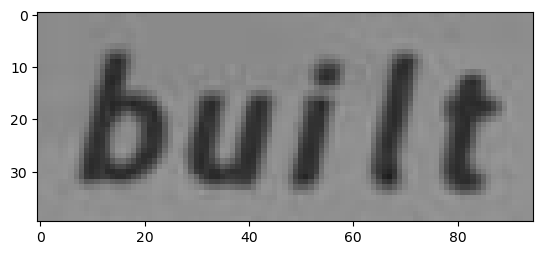

built<EOW>
built<EOW>
18 0.5074860453605652


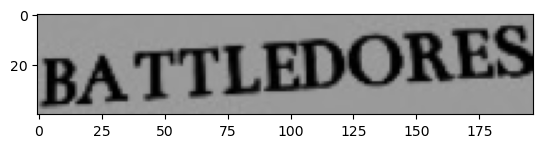

RATTLEDORES<EOW>
BATTLEDORES<EOW>
19 0.5795421600341797


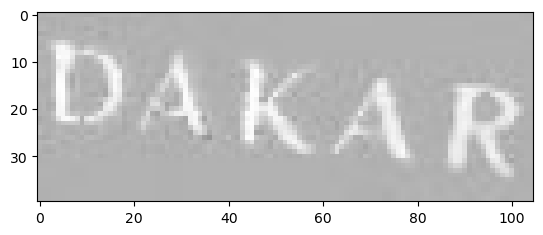

DAKAR<EOW>
DAKAR<EOW>
20 0.32684525847435


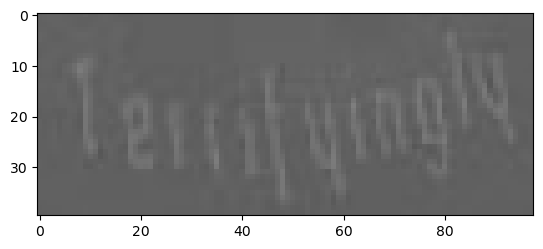

letime<EOW>
Terrifyingly<EOW>
21 0.3328807055950165


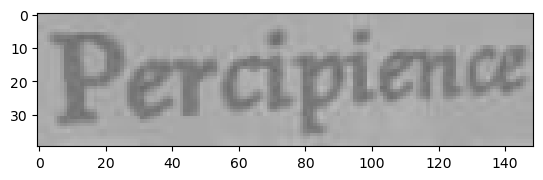

Percipiene<EOW>
Percipience<EOW>
22 0.17312687635421753


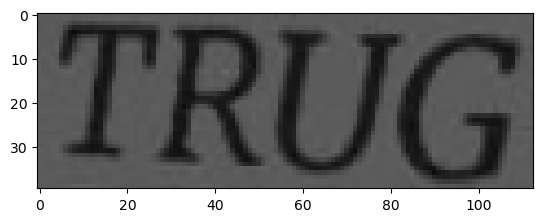

TRUG<EOW>
TRUG<EOW>
23 0.11515189707279205


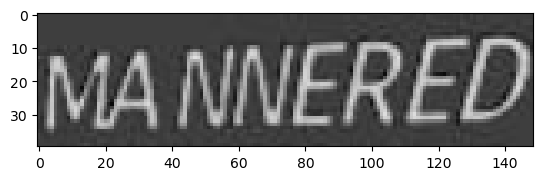

MANNERED<EOW>
MANNERED<EOW>
24 0.18565471470355988


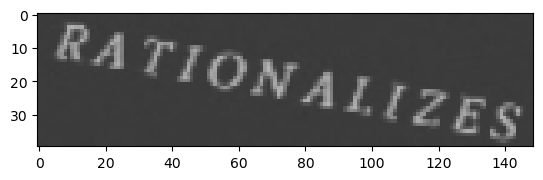

CATOMALIES<EOW>
rationalizes<EOW>
25 0.1745864450931549


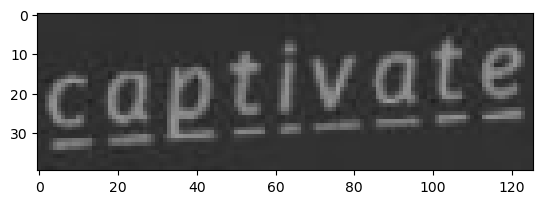

coptivats<EOW>
captivate<EOW>
26 0.20275945961475372


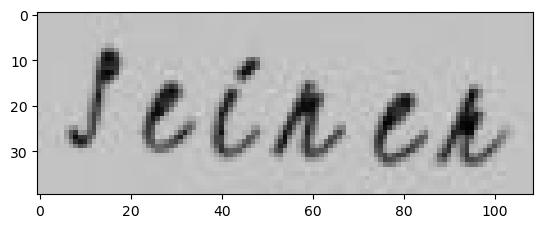

letner<EOW>
Seiner<EOW>
27 0.18116873502731323


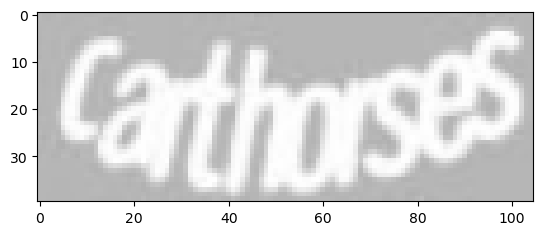

Catdinges<EOW>
carthorses<EOW>
28 0.07594453543424606


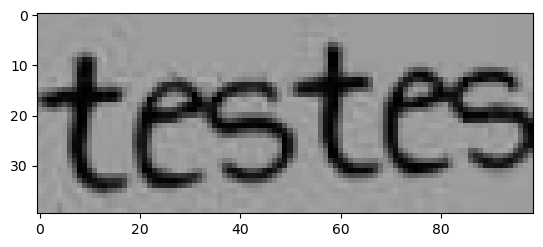

testes<EOW>
testes<EOW>
29 0.2004270851612091


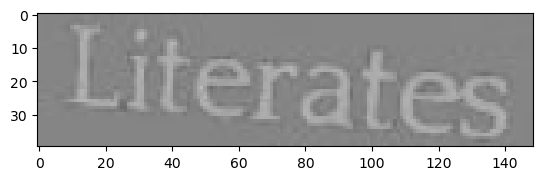

Literates<EOW>
Literates<EOW>
30 0.06666842103004456


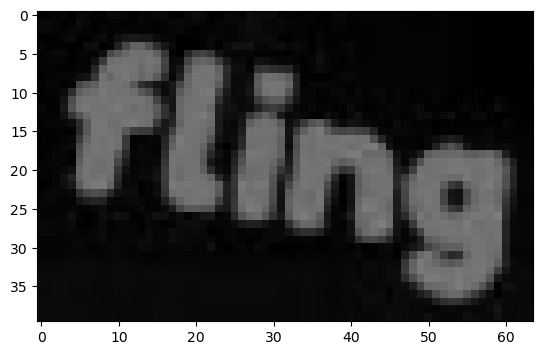

fling<EOW>
fling<EOW>
31 0.1082223653793335


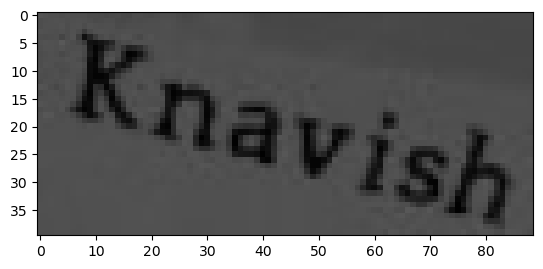

Knatiesh<EOW>
Knavish<EOW>
32 0.06827598065137863


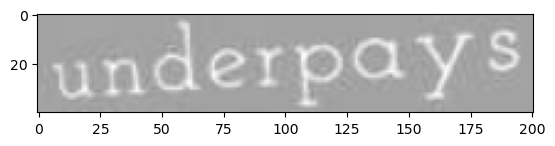

underpays<EOW>
underpays<EOW>
33 0.08131320029497147


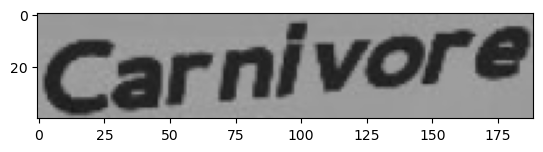

Carnivore<EOW>
Carnivore<EOW>
34 0.0649917721748352


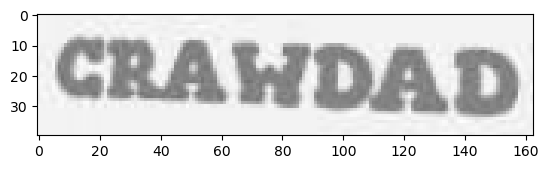

CRAMDAD<EOW>
CRAWDAD<EOW>
35 0.08858571201562881


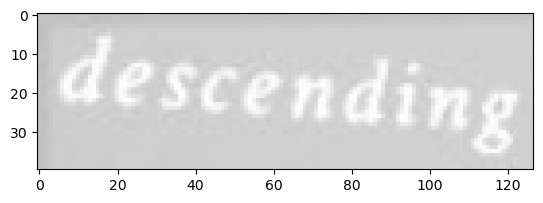

derenting<EOW>
descending<EOW>
36 0.10199582576751709


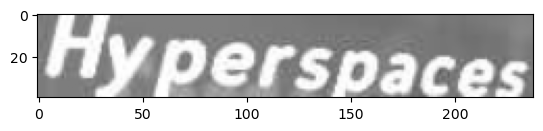

hypersdasces<EOW>
Hyperspaces<EOW>
37 0.03234388306736946


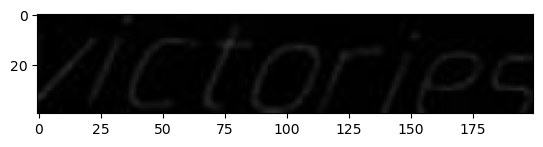

MCtories<EOW>
victories<EOW>
38 0.039360228925943375


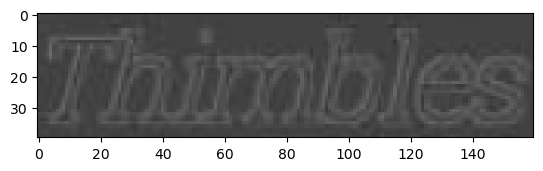

Thimbles<EOW>
Thimbles<EOW>
39 0.0424976572394371


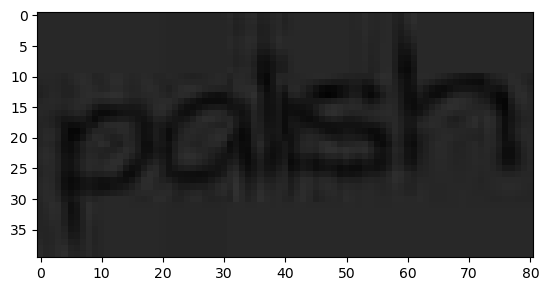

polstn<EOW>
palish<EOW>
40 0.025370238348841667


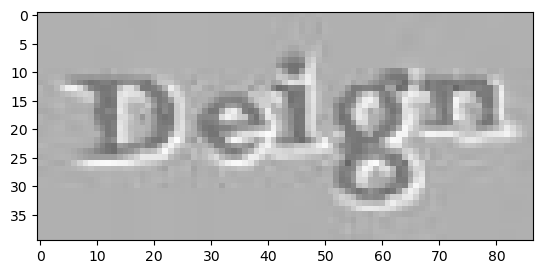

Deign<EOW>
Deign<EOW>
41 0.08959708362817764


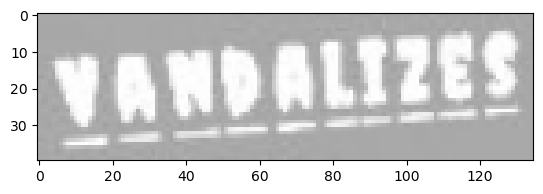

YAMDCLNES<EOW>
Vandalizes<EOW>
42 0.49379023909568787


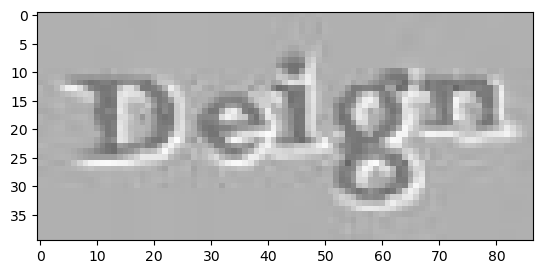

Deilgn<EOW>
Deign<EOW>
43 0.07251888513565063


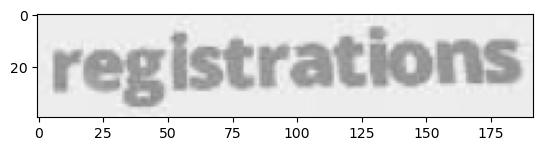

registrations<EOW>
registrations<EOW>
44 0.04402276501059532


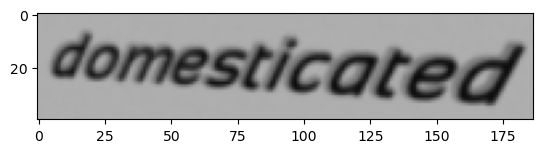

domesticued<EOW>
domesticated<EOW>
45 0.035666704177856445


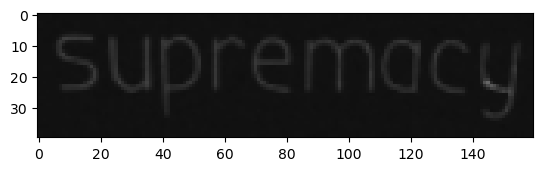

supTemacy<EOW>
supremacy<EOW>
46 0.020693451166152954


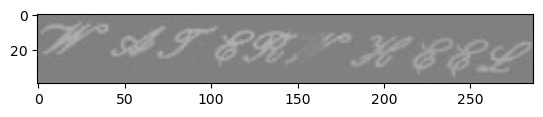

TULTZHESS<EOW>
WATERWHEEL<EOW>
47 0.03951171413064003


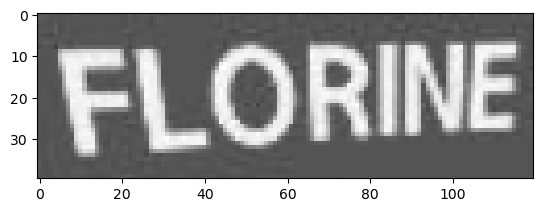

FLORIE<EOW>
FLORINE<EOW>
48 0.01982293277978897


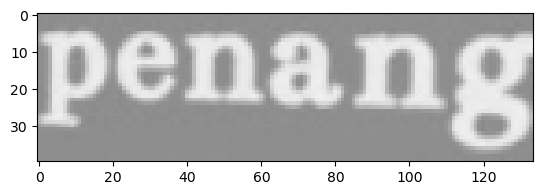

penang<EOW>
penang<EOW>
49 0.024643462151288986


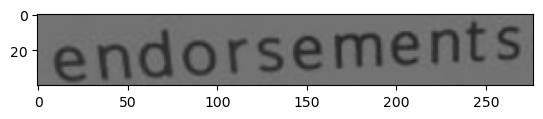

endorsements<EOW>
endorsements<EOW>
50 0.040652044117450714


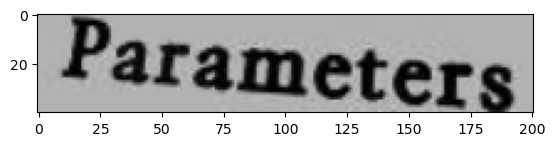

Paramcters<EOW>
Parameters<EOW>
51 0.07744430005550385


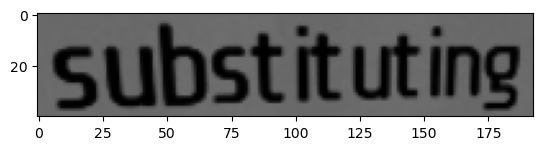

substituting<EOW>
substituting<EOW>
52 0.03908547759056091


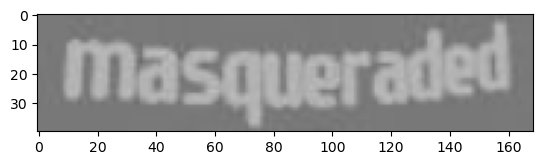

masueraded<EOW>
masqueraded<EOW>
53 0.011923002079129219


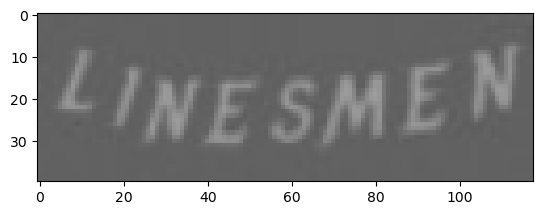

Limgsher<EOW>
linesmen<EOW>
54 0.011807223781943321


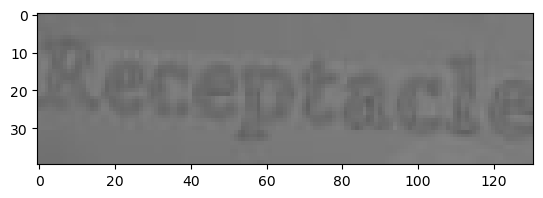

Pereptodle<EOW>
Receptacle<EOW>
55 0.07678051292896271


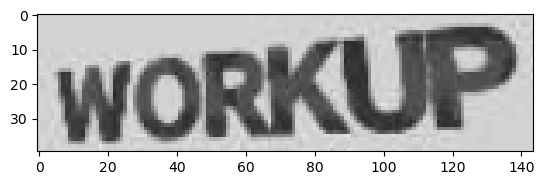

WORKUP<EOW>
WORKUP<EOW>
56 0.04946582391858101


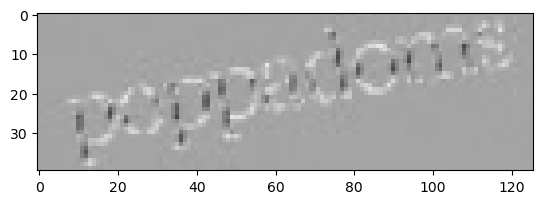

peugeions<EOW>
poppadoms<EOW>
57 0.024264933541417122


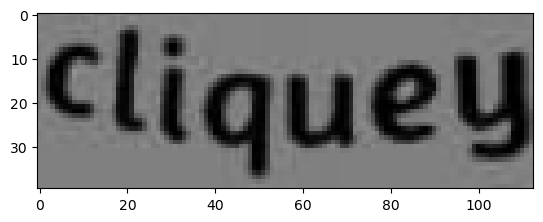

cliquey<EOW>
cliquey<EOW>
58 0.31738078594207764


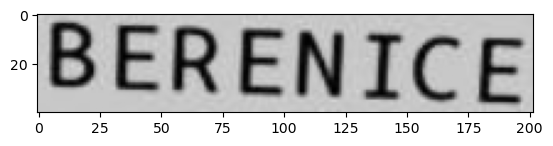

BERENTCE<EOW>
BERENICE<EOW>
59 0.01222473569214344


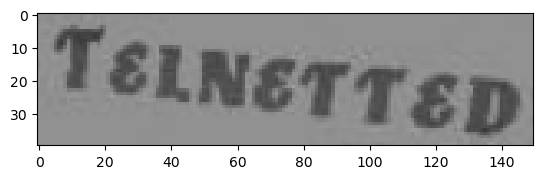

TelNettEd<EOW>
Telnetted<EOW>
60 0.04694166034460068


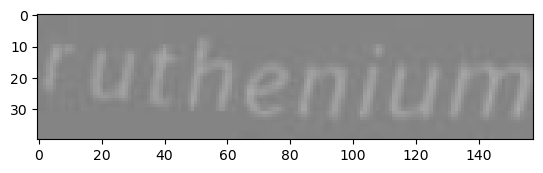

rutheniun<EOW>
ruthenium<EOW>
61 0.022575881332159042


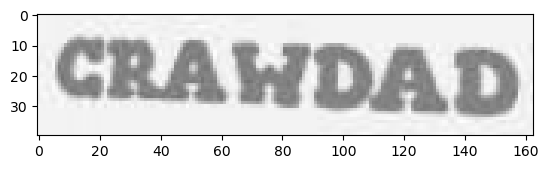

CRAMDAD<EOW>
CRAWDAD<EOW>
62 0.010612551122903824


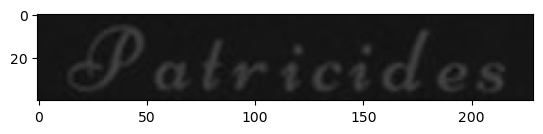

Dairicides<EOW>
Patricides<EOW>
63 0.027633709833025932


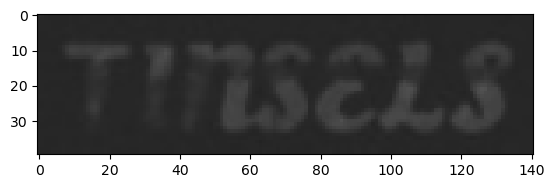

TinsELS<EOW>
TINSELS<EOW>
64 0.047082386910915375


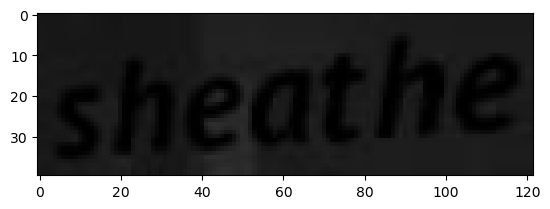

sheathe<EOW>
sheathe<EOW>
65 0.04198213666677475


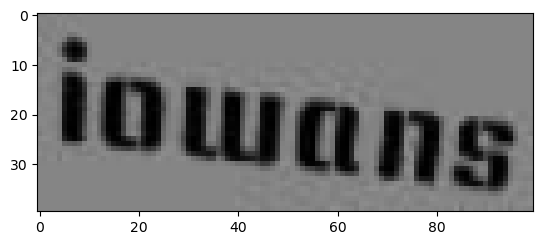

iounns<EOW>
iowans<EOW>
66 0.008526526391506195


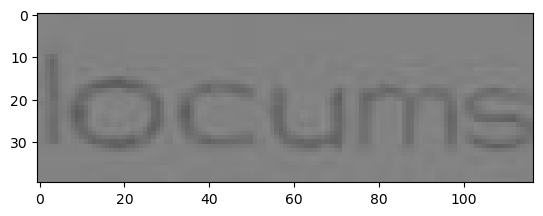

ocums<EOW>
locums<EOW>


KeyboardInterrupt: 

In [15]:
train()